TODO:
- Better explanation of priors
- Add more explanatory text
- Make sure the conclusion of hypothesis is clear 
- Better explain posterior results
- Add clarity of trace plots.
- Decide which data visualizations we would like to include? Boxplot, mean ...

# Energy consumption of a Web Application Implemented in Different Programming Languages and Web Frameworks
*Probabilistic Programming 2025 Exam by Raúl Pardo ([raup@itu.dk](mailto:raup@itu.dk)) and Andrzej Wąsowski ([wasowski@itu.dk](mailto:wasowski@itu.dk))*<br/>
*version 1.0.0 2025-03-20 08:40*


In this exam, your task is to analyze energy consumption of different implementations of a web application.
The goal is to determine whether there are differences in energy consumption in different implementations of the web application or in its API endpoints.
This analysis is of utmost importance, as it might help software engineers to make informed choices that lower energy consumption. For instance, a plausible hypothesis is that lower level programming languages such as Rust consume less energy than higher level languages such as Python.
A preconception in this domain is that running time is the driving factor in energy consumption.
Are these true? The data in this exam and the analysis you will develop will allow to answer this type of questions.

## Data

The dataset contains $N = 1960$ measurements of energy consumption for different implementations and functionality of a web application. For each setup, there are 20 measurements. The dataset is in the file [dataset.csv](dataset.csv). The variables in the dataset are:

* **Application**. This variable has the form `<programming_language>-<web_framework>`. It specifies the programming language and web framework used in the experiment. For instance, `rust-actix` denotes the web framework Actix for the programming language Rust, or `c-sharp-razor` denotes the web framework Razor for the programming language C#.
    * Note that if a hypothesis involves only programming language, you need to extract it from the values in this variable.

* **Endpoint**. This variable refers to the API endpoints of the web application. For example, `/api/register` refers to the API endpoint used for registering users in the web application, or `/logout` is used for logging out of the system.

* **Runtime**. This variable indicates the time it took to process the request to the endpoint in seconds.

* **Energy consumption**. This variable indicates the energy consumed for processing the request to the endpoint in Joules.

Each row in the dataset is a measurement of the total energy consumed and runtime after processing a request in the corresponding API endpoint. The *Application* variable in each row indicates the web framework used for the measurement.

## Hypotheses

To analyze energy consumption in the different implementations, you must investigate the following hypotheses:

* **H1** - The web framework `c-sharp-razor` consumes more energy than any other web framework in the dataset.

* **H2** - The programming language `javascript` consumes the least amount of energy compared to any other programming language in the dataset.

* **H3** - Runtime has a stronger impact on energy consumption for some API endpoints than others. That is, the effect of runtime on energy consumption is larger for some API endpoints than others.

Your task is to use Bayesian Inference and Regression to decide whether these hypotheses hold, or possibly reject them. This includes:

* Loading, restructuring and transforming the data as needed.

* Designing Bayesian regression models and using inference algorithms to test the above hypotheses in PyMC.

* Explaining your model idea in English, preferably using a figure, and showing the Python code.

* Checking and reflecting (in writing) on the quality of the sampling process, considering warnings from the tool, sampling summary statistics, trace plots, and autocorrelation plots. Comment whether the quality of the sampled trace is good, and whether you had to make any adjustments during modeling and/or sampling.

* Visualizing the posterior information appropriately to address the hypotheses.
  

You should hand in a zip file with a Jupyter notebook and the data file (so that we can run it), and a **PDF file rendering of the Jupyter notebook**, so that your work can be assessed just by reading this file. It appears that the best PDF rendering is obtained by File / Export to HTML, and then saving/printing to PDF from your browser.

Make sure the notebook is actually a **report** readable to the examiners, especially to the censor who has not followed the course. The report should include:
* A brief introduction.
* Explanations on how data is loaded and cleaned.
* Explanations on analysis and model design (for each of the models you consider).
* A discussion of sampling quality (for each model) and all the plots that you present, and a reflection/decision on the outcome for each hypothesis.
* An overall conclusion.

**IMPORTANT:** For the tasks below, your code must accompany an explanation of its meaning and intended purpose. **Source code alone is not self-explanatory**. As mentioned above, you should also reflect on the results you get, e.g., highlighting issues with the data, or issues, pitfalls and assumptions of a model. **Exams containing only source code or very scarce explanations will result in low grades, including failing grades.**





## Minimum requirements 

1. Design a regression model to predict energy consumption using web framework as a predictor.
  
2. Analyze hypothesis H1 using the regression model in (1.).

## Ideas for extension

**Groups aiming at grade 7 and more should complete the following tasks:**
    
3. Analyze hypothesis H2, if necessary design a new model.
        
4. Perform prior predictive checks in all your models. Explain why the priors you selected are appropriate.
    
5. Perform posterior predictive checks in all your models. Discuss the results in the posterior predictive checks.
    
6. Discuss trace convergence in all your models.
    
**Groups aiming at grade 10 and higher should try 3-5 ideas from below or add some of your own:**

7. Analyze hypothesis H3, if necessary design a new model.
    
8. Perform a counterfactual analysis in your model for H3: For each endpoint, plot posterior predictions on energy consumption for a runtime value much larger than those in the dataset. Does this affect/introduce differences between energy consumption for different endpoints?
    
9. Design models with a transformation of the predicted variable, i.e., energy consumption. For instance, 
    * Build a model to analyze the probability that the energy consumption of a web framework is below 0.4 Joules. You may consider versions of this task involving other predictors.
    * Transform energy consumption into an ordinal variable representing an energy mark, e.g., an energy consumption in 0.0-0.2 is energy mark A, energy consumption in 0.2-0.4 is energy mark B and energy consumption of ≥ 0.4 is energy mark C. Use an ordinal regression model to analyze the energy mark of each framework. You may consider versions of this task involving other predictors.
    
10. Use information criteria to compare the models to analyze H1, H2 and H3.
    
11. Design a meaningful multilevel model in the context of these data.
   
12. Use causal reasoning to analyze causal relations between the variables in the dataset.

---

# Exam Prpro 2025 - Group Nickelback

**TODO: Front page**

## The problem

In this report we explore the energy consumption of different programming languages and framework. Specfically, we want to explore the difference in energy consumption across different implementations of web applications. We are given data from executing requests to these web applications that we will use for our analysis.

### Introducing the data

The information that we have been given about the data is that there are four columns in our dataset:

- Application:
  - Formatted with `<programming_language>-<web_framework>`
- Endpoint:
  - The path of the endpoint like `/api/register`
- Energy_consumption:
  - The energy consumption of the for processing a request to an endpoint in Joules.
  - Because of physics we can not have negative energy consumption, so we can assume that the energy consumption is always positive.
- Runtime:
  - The time it took to process a request to an endpoint in seconds.
  - Because of physics we can not have negative time, so we can assume that the time is always positive.


Let's first import libraries and read the data into a dataframe.

In [2]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import xarray as xr
import scipy.stats as stats
import seaborn as sns
rng = 42

In [3]:
df = pd.read_csv('dataset.csv')

With the data we can start exploring the data format, so we have an idea of what we are working with.

In [4]:
df

,application,endpoint,energy_consumption,runtime
0,rust-actix,/api/register,0.449358,0.148812
1,rust-actix,/api/register,0.433871,0.148895
2,rust-actix,/api/register,0.270844,0.094729
3,rust-actix,/api/register,0.479776,0.163467
4,rust-actix,/api/register,0.268833,0.092300
...,...,...,...,...
1955,javascript-express,/logout,0.096436,0.032214
1956,javascript-express,/logout,0.097559,0.032214
1957,javascript-express,/logout,0.096922,0.032214
1958,javascript-express,/logout,0.097086,0.032214


It would be interesting to see how many different applications and endpoints we have in our dataset.

In [5]:
df.endpoint.unique().tolist()

['/api/register',
 '/api/msgs/user0',
 '/api/msgs',
 '/api/fllws/user',
 '/api/unfllws/user',
 '/api/latest',
 '/register',
 '/login',
 '/user/follow',
 '/add_message',
 '/public',
 '/user/user0',
 '/user/unfollow',
 '/logout']

We see that the dataset contains a total of 14 different endpoints.

In [6]:
df.application.unique().tolist()

['rust-actix',
 'ruby-sinatra',
 'go-gorilla',
 'go-gin',
 'python-flask',
 'c-sharp-razor',
 'javascript-express']

And the dataset contains seven different applications.

Just to be sure lets check that all applications have the same number of measurements.

In [7]:
df.groupby('application').endpoint.nunique().reset_index().sort_values('endpoint', ascending=False)

,application,endpoint
0,c-sharp-razor,14
1,go-gin,14
2,go-gorilla,14
3,javascript-express,14
4,python-flask,14
5,ruby-sinatra,14
6,rust-actix,14


#### Let's try to understand the data a little better

The first thing we check is the average energy consumption for each application:

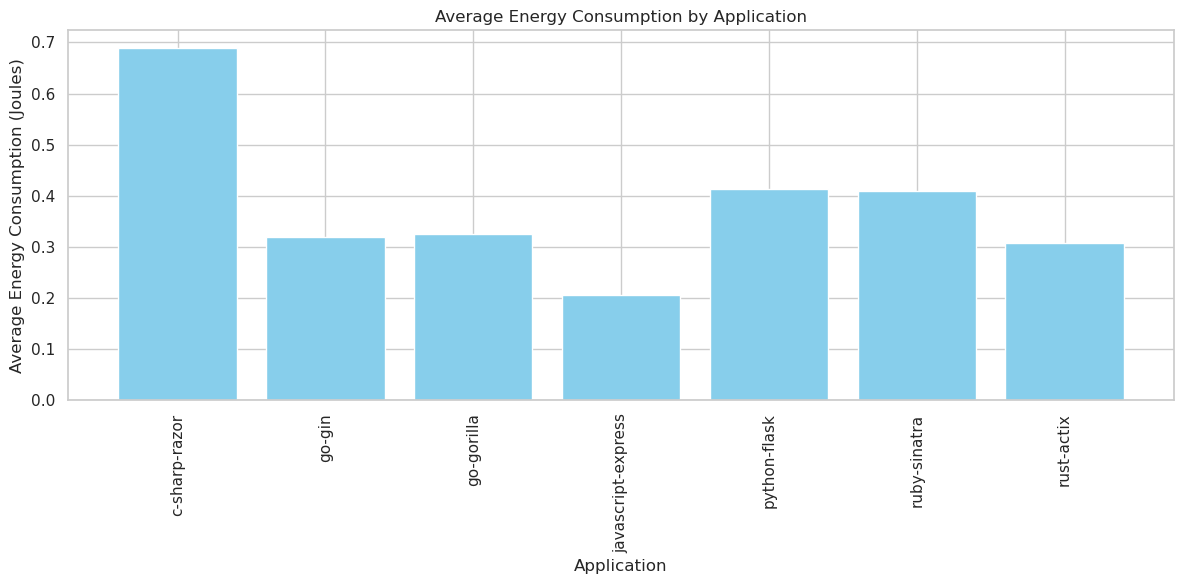

In [48]:
# Group by 'Application' and calculate the average energy consumption
avg_energy_consumption = df.groupby('application')['energy_consumption'].mean().reset_index()

# Plot the average energy consumption for each application
plt.figure(figsize=(12, 6))
plt.bar(avg_energy_consumption['application'], avg_energy_consumption['energy_consumption'], color='skyblue')
plt.xlabel('Application')
plt.ylabel('Average Energy Consumption (Joules)')
plt.title('Average Energy Consumption by Application')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

We see that `c-sharp-razor` has the highest energy consumption, while `javascript-express` has the lowest energy consumption. This already indicates that we can approve the first hypothesis that `c-sharp-razor` consumes more energy than any other web framework in the dataset, if we look at the average energy consumption.


**Digging deeper into the data**

But lets try to understand the data a little better. To get an overview of the data we make a boxplot for each application of the energy consumption in relation to the runtime. 

To test our 

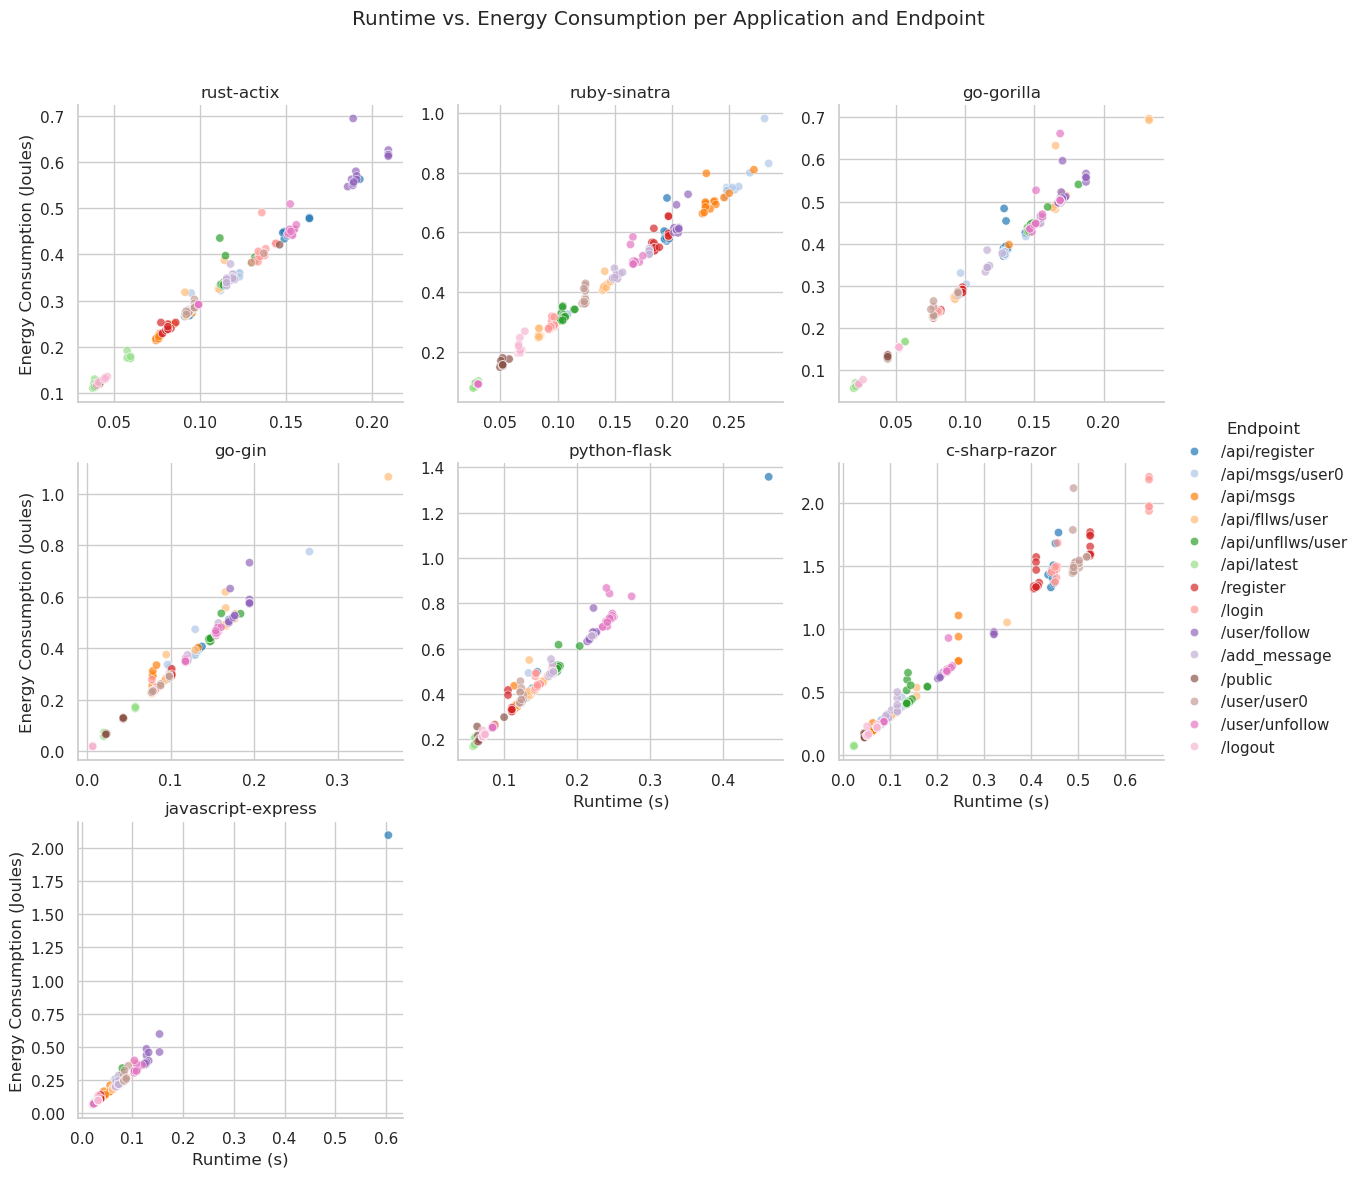

In [8]:
sns.set_theme(style="whitegrid")

# Use a more vibrant color palette
palette = sns.color_palette("tab20", n_colors=14)

# Create the FacetGrid with custom palette
g = sns.FacetGrid(df, col="application", col_wrap=3, sharex=False, sharey=False, height=4)
g.map_dataframe(sns.scatterplot, x="runtime", y="energy_consumption", hue="endpoint", palette=palette, alpha=0.7)

# Clean up the layout
g.set_axis_labels("Runtime (s)", "Energy Consumption (Joules)")
g.set_titles(col_template="{col_name}")
g.add_legend(title="Endpoint")
g.figure.subplots_adjust(top=0.9)
g.figure.suptitle("Runtime vs. Energy Consumption per Application and Endpoint")

plt.show()

An initial look makes it look like most applications have a linear relationship between energy consumption and runtime. Most applications also seem to have a low variance in energy consumption apart from `c-sharp-razor` which has a high variance with more outliers.
We can also see that the `c-sharp-razor` application has a higher energy consumption than the other applications. This is interesting because it is one of the hypotheses we want to test.

Lets look at the endpoints for `c-sharp-razor` to see if we can see if there is a specific endpoint that is causing the high energy consumption and outliers.

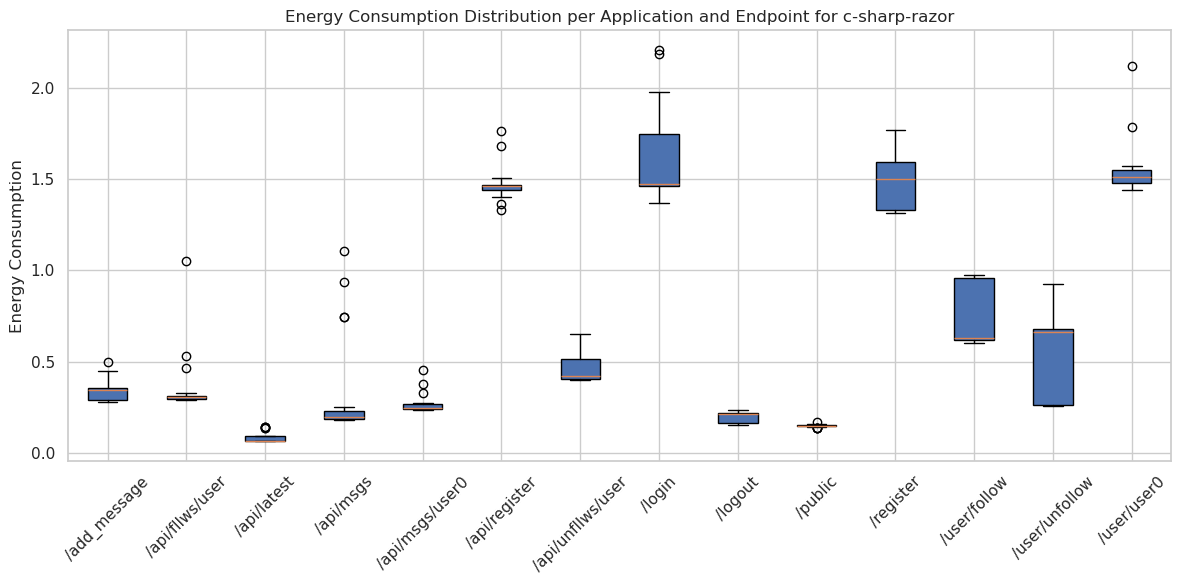

In [ ]:
target = "c-sharp-razor"
# target = "javascript-express"
csharpdata = df.where(df["application"] == target)
data = csharpdata
grouped = [ group["energy_consumption"].values for _, group in data.groupby(["endpoint"]) ]
labels = data.groupby(["endpoint"]).groups.keys()

plt.figure(figsize=(12, 6))
plt.boxplot(grouped, tick_labels=labels, patch_artist=True)
plt.title(f"Energy Consumption Distribution per Application and Endpoint for {target}")
plt.ylabel("Energy Consumption")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



It seems that dotnet has some relavtive low variance in energy consumption for most of the endpoints, as long as we disregard the outliers. 

## Data transformations

To give ourself access to the frame work and simplify access to the most common variables, we will do a few data transformations:
- We will extract `language` $L$ and `framework` $F$ into separate data columns
- For the analysis we will need to work with categorical data, specfically the columns `application` $A$, `language` $L$, and `framework` $F$.
- And we will standardize `running time` $R$ and `energy consumption` $C$, because regression models work better with variables of similar scale.

In [10]:
language, framework = list(zip(*df["application"].apply(lambda a: a.split("-") if not a.startswith("c-sharp") else [a[0:7], a[8:]])))
df["language"] = list(language)
df["L"] = df["language"]
df["framework"] = list(framework)
df["F"] = list(framework)

Next we will create a standadized $R_{stand}$ and $C_{stand}$ column, so high outliers will not affect the model too much. 

The formular for standardization is:
$$X_{stand} = \frac{X - median(X)}{Std(X)}$$
Where $Std(X)$ is the standard deviation.


In [12]:
df["R_stand"] = (df["R"] - df["R"].mean()) / df["R"].std()
df["C_stand"] = (df["C"] - df["C"].mean()) / df["C"].std()

The next cell will create indexes for the categorical data columns

In [11]:
cats = pd.Categorical(df["application"])
L_cats = pd.Categorical(df["language"])
F_cats = pd.Categorical(df["framework"])
df["A"] = cats.codes
df["L"] = L_cats.codes
df["F"] = F_cats.codes
df["C"] = df["energy_consumption"]
df["R"] = df["runtime"]

print("Application code to to its category label:")
for code, label in enumerate(cats.categories):
    print(f"  {code}: {label}")

Application code to to its category label:
  0: c-sharp-razor
  1: go-gin
  2: go-gorilla
  3: javascript-express
  4: python-flask
  5: ruby-sinatra
  6: rust-actix


Let's take a look at the final *dataframe* with all our data transformations applied

In [13]:
df

,application,endpoint,energy_consumption,runtime,language,L,framework,F,A,C,R,R_stand,C_stand
0,rust-actix,/api/register,0.449358,0.148812,rust,5,actix,0,6,0.449358,0.148812,0.257760,0.226844
1,rust-actix,/api/register,0.433871,0.148895,rust,5,actix,0,6,0.433871,0.148895,0.258643,0.175329
2,rust-actix,/api/register,0.270844,0.094729,rust,5,actix,0,6,0.270844,0.094729,-0.317940,-0.366952
3,rust-actix,/api/register,0.479776,0.163467,rust,5,actix,0,6,0.479776,0.163467,0.413760,0.328024
4,rust-actix,/api/register,0.268833,0.092300,rust,5,actix,0,6,0.268833,0.092300,-0.343796,-0.373640
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1955,javascript-express,/logout,0.096436,0.032214,javascript,2,express,1,3,0.096436,0.032214,-0.983395,-0.947085
1956,javascript-express,/logout,0.097559,0.032214,javascript,2,express,1,3,0.097559,0.032214,-0.983395,-0.943350
1957,javascript-express,/logout,0.096922,0.032214,javascript,2,express,1,3,0.096922,0.032214,-0.983395,-0.945470
1958,javascript-express,/logout,0.097086,0.032214,javascript,2,express,1,3,0.097086,0.032214,-0.983395,-0.944924


## Testing Hypothesis 1

In this section we will test the hypothesis that `c-sharp-razor` consumes more energy than any other web framework in the dataset.

The first step will be to create a simple model with a single intercept per application ($A$).

Let's build a simple model:
$$
\begin{aligned}
    C &\sim \text{Normal}(\mu, \sigma) \\
    \mu &\sim \alpha_{[A[i]]} \\
    \alpha &\sim \text{Normal}(0,2) \\
    \sigma &\sim \text{Exponential}(1)
\end{aligned}
$$

**Why these distributions?**

The reasoning for choosing distributions for the priors is as follows. It is important to note that we have standardized the data, so if values is negative, it just means it is below the mean of the data and not that it is negative:

- **$\alpha \sim \text{Normal}(0,2)$**: We don't have a good intuition about the intercepts of the different applications. Therefore, we default to a normal distribution with a mean of 0 and a standard deviattion of 2. This means we expect the intercepts to be between -4 and 4 with a 95% probability. We believe that defaulting to a normal distribution is the most reasonable choice given one doesn't have an intuition about the distribution.
- **$\mu \sim \alpha_{[A[i]]}$**: Our mean is the intercept of each application of the model. We try to keep the model as simple as possible for a start, so we keep the number of perameters to a minimum.
- **$\sigma \sim \text{Exponential}(1)$**: We know that the standard deviation of the outcome variable is positive. Therefore, we choose an exponential distribution with a mean of 1. This means we expect the standard deviation to be between 0 and 2 with a 95% probability.
- **$C \sim \text{Normal}(\mu, \sigma)$**: We are working with standardized energy consumption, so we try to fit it to a normal distribution around 0. We chose a normal dirstribution at the lack of better options with our current knowledge.     

**Prior predictive check**

Before we start constructing any models with these priors, the first step will be checking our priors are sensible, by doing a prior predictive check:

In [14]:
np.random.seed(rng)
n_samples = 1000
alpha_mean = 0
alpha_std = 2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
x = np.linspace(-7,7,n_samples)
alpha_sample = stats.norm.pdf(x, alpha_mean, alpha_std)
sigma_sample = stats.expon.pdf(x, 1)
ax1.plot(x, alpha_sample)
ax1.set_title(f"Prior of alpha - Normal({alpha_mean},{alpha_std})")

alpha_sample = stats.norm.rvs(loc=alpha_mean, scale=alpha_std, size=n_samples)
sigma_sample = stats.expon.rvs(scale=1.0, size=n_samples)
prior_c = stats.norm.rvs(loc=alpha_sample, scale=sigma_sample)

az.plot_kde(prior_c, ax=ax2)
ax2.set_xlabel("Energy consumption")
ax2.set_title(f"Prior for C - Normal(loc=alpha, scale=sigma)")
ax2.set_yticks([])

plt.tight_layout()
plt.show()

The prior for $C$ looks reasonable, since we are working with standardized energy consumption values. We see the values are around 0 which is what we expect for the standardized values. For $\alpha$ we are also satisfied since it allows both positive and negative values, allowing values that either push energy consumption of an application to be better (-) or worse (+) than the mean energy consumption.

In [15]:
with pm.Model() as m_h1_only_intercept:
    C_data = pm.Data("C_data", df["C_stand"].values, mutable=True)
    A_data = pm.Data("A_data", df["A"].values, mutable=True)

    alpha = pm.Normal("alpha", 0, 2, shape=df["A"].unique().size)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", alpha[A_data])

    C = pm.Normal("C", mu=mu, sigma=sigma, observed=C_data)

    diff = pm.Deterministic("diff", alpha - alpha[0])

    trace_h1_only_intercept = pm.sample(random_seed=rng, idata_kwargs = { 'log_likelihood': True })

/home/chobbie/anaconda3/envs/prpro-2025/lib/python3.12/site-packages/pymc/data.py:440: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


**Sampling**

Next, we will consider the sampling process, starting with a trace plot:

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

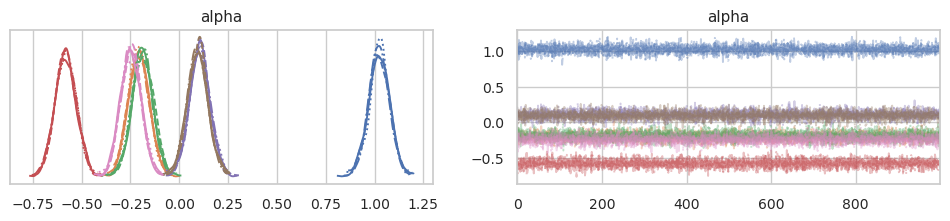

In [16]:
az.plot_trace(trace_h1_only_intercept, var_names=["alpha"])

Looking at the trace plot - the sampling process looks successful. Specfically, in the right hand side of the plot we see good mixing (read: *zig zagging*) and good convergance (chains are sticking to the same high probability areas). 

In [46]:
az.summary(trace_h1_only_intercept, var_names=["alpha", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],1.024,0.053,0.923,1.125,0.001,0.000,5938.0,2640.0,1.0
alpha[1],-0.207,0.053,-0.307,-0.108,0.001,0.001,5279.0,3263.0,1.0
alpha[2],-0.188,0.054,-0.286,-0.080,0.001,0.001,5611.0,3039.0,1.0
alpha[3],-0.581,0.054,-0.678,-0.477,0.001,0.001,5651.0,3223.0,1.0
alpha[4],0.106,0.053,0.001,0.203,0.001,0.001,5045.0,3140.0,1.0
alpha[5],0.094,0.053,-0.010,0.193,0.001,0.001,6017.0,3386.0,1.0
alpha[6],-0.247,0.052,-0.343,-0.148,0.001,0.001,5138.0,2954.0,1.0
sigma,0.884,0.014,0.856,0.910,0.000,0.000,5478.0,2994.0,1.0


Looking at the summary of the simulation, firstly we see that the $\hat r$ values are all 1, again suggesting that the sampling process was successful (and similarly the effective sample size (ess_bulk) is also high). 

Interestingly, considering only the alpha parameters, we see that the mean $\alpha$ is highest for the category 0 (`c-sharp-razor`), and the model is fairly confident (low standard deviation).

**What do the results describe?**

The results discribe the likelihood of the intercept parameters for each application taking on specific values. For example, we see that the inctercept parameter for `c-sharp-razor` is likely to have a value around $1.024$. Another way of describing the result is to say that we have modelled out confidence that the intercept parameter for `c-sharp-razor` is in the span $0.9$ to $1.1$ with 97% probability (Becuase the Highest Density Interval (HDI) describes the region where the PDF of the parameter has 97% of its density).

Similarly, we see our confidence of the sigma paramter is quite high to be in the range of $0.856$ to $0.910$.

Next, let us plot the contrasts ($\alpha - \alpha_{\text{c-sharp-razor}}$):

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

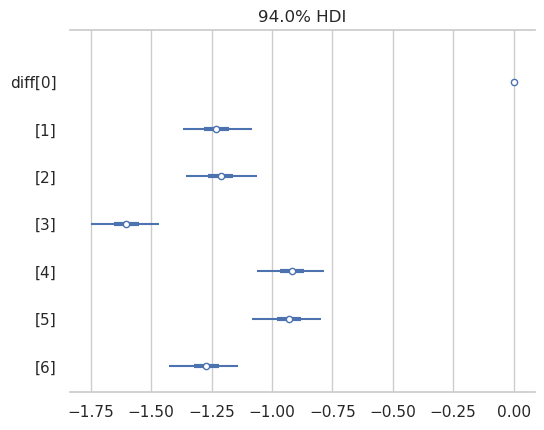

In [18]:
az.plot_forest(trace_h1_only_intercept, var_names=["diff"], combined=True)

Recall that $0$ (zero) is the application `c-sharp-razor`. We see from the forest plot of contrasts above that they are all sitting well to the left of 0.0, meaning that the energy consumption of `c-sharp-razor` is higher than all the other language/frameworks.

**Posterior predictive check**

First we sample the posterior using pymc

In [19]:
with m_h1_only_intercept:
    pm.sample_posterior_predictive(trace_h1_only_intercept, extend_inferencedata=True, random_seed=rng)

Sampling: [C]


Output()

array([<Axes: xlabel='C'>], dtype=object)

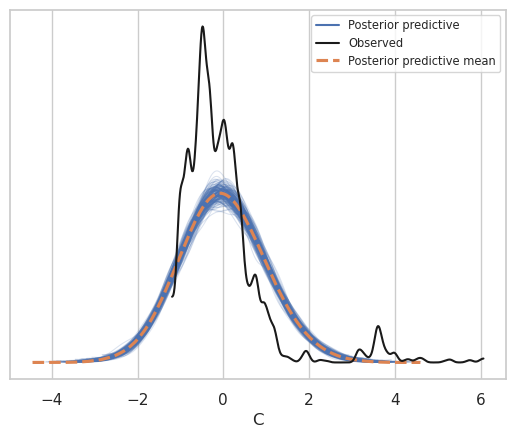

In [20]:
_, ax = plt.subplots()
az.plot_ppc(trace_h1_only_intercept, num_pp_samples = 200, ax=ax)

Looking at the posterior, we see that our model is skewed, the peak of our model is slightly to the right of the observed values. What happened? We know from our domain knowledge as software developers that when executing computer programs there is a potential of heavy tails due to garbage collection, Just-In-Time compilation, operating system context switching etc. This actually means that our model is supposed to work in world where outliers are rare but not impossible, we could try switching our $\text{Normal}$ distribution for the outcome variable to a $\text{StudentT}$ distribution.

### Improving the model



Using these observations lets build another model:
$$

\begin{aligned}
    C &\sim \text{StudentT}(\mu, \sigma) \\
    \mu &\sim \alpha_{[A[i]]} \\
    \alpha &\sim \text{Normal}(0,1) \\
    \sigma &\sim \text{Exponential}(1)
\end{aligned}

$$



As before, we will do a prior predictive check in order to verify that $\alpha, \sigma$, and our choice of $\text{StudentT}$ lead to a satisfactory prior for $C$. 

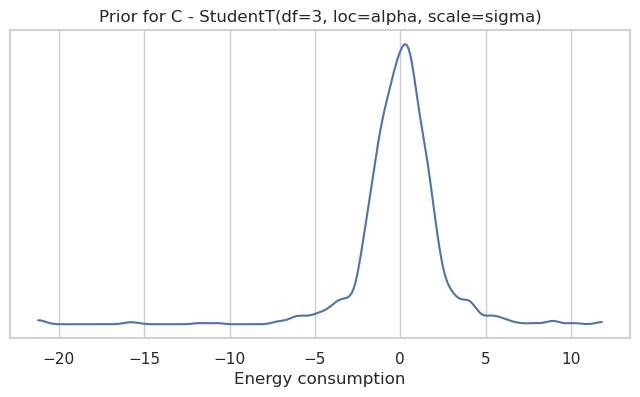

In [41]:
np.random.seed(rng)
fig, (ax2) = plt.subplots(1, 1, figsize=(8, 4))

alpha_sample = stats.norm.rvs(loc=alpha_mean, scale=alpha_std, size=n_samples)
sigma_sample = stats.expon.rvs(scale=1.0, size=n_samples)
prior_c = stats.t.rvs(df=3, loc=alpha_sample, scale=sigma_sample)

az.plot_kde(prior_c, ax=ax2)
ax2.set_xlabel("Energy consumption")
ax2.set_title(f"Prior for C - StudentT(df={3}, loc=alpha, scale=sigma)")
ax2.set_yticks([])
plt.show()

The new prior for $C$ encapsulates our domain knowledge as bias, it is now less sensitive to outliers.

We are now able to implement the model using PYMC

In [22]:
with pm.Model() as m_h1_studentT:
    C_data = pm.Data("C_data", df["C_stand"].values, mutable=True)
    A_data = pm.Data("A_data", df["A"].values, mutable=True)

    alpha = pm.Normal("alpha", 0, 2, shape=df["A"].unique().size)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", alpha[A_data])

    C = pm.StudentT("C", nu=3, mu=mu, sigma=sigma, observed=C_data)

    diff = pm.Deterministic("diff", alpha - alpha[0])

    trace_h1_studentT = pm.sample(random_seed=rng, idata_kwargs = { 'log_likelihood': True })

/home/chobbie/anaconda3/envs/prpro-2025/lib/python3.12/site-packages/pymc/data.py:440: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


**Sampling**

Let's consider the sampling process. Let us plot the trace:

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

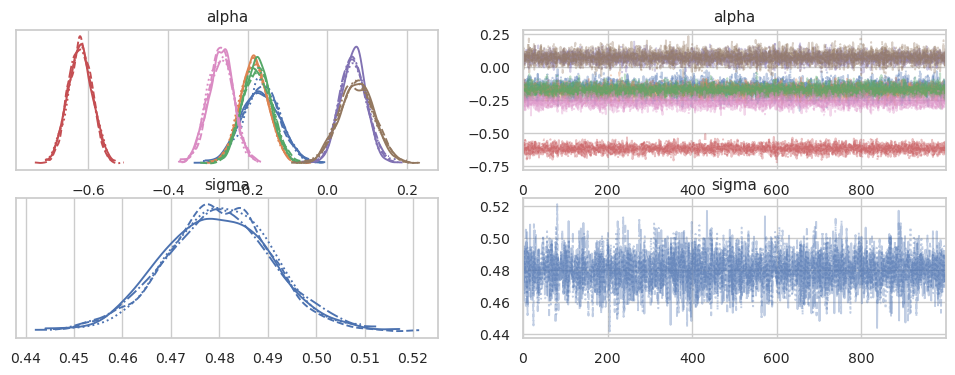

In [23]:
az.plot_trace(trace_h1_studentT, var_names=["alpha", "sigma"])

The sampling trace looks good. We see solid *mixing* in the right hand side plot, where the lines are zig-zagging up and down whilst sticking to the same high probability areas (good *stationarity*). Shifting our attention to the left plot, we see good *convergance* as the indepdent chains are sticking to the same regions (the different line styles indicate chains, solid, dashed etc.).

Next, we will consider the $\hat r$ and effective-sample size.

In [ ]:
az.summary(trace_h1_studentT, var_names=["alpha", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.166,0.047,-0.250,-0.077,0.001,0.0,4600.0,3435.0,1.0
alpha[1],-0.184,0.035,-0.251,-0.121,0.000,0.0,5198.0,3396.0,1.0
alpha[2],-0.177,0.036,-0.244,-0.112,0.000,0.0,5432.0,2832.0,1.0
alpha[3],-0.621,0.030,-0.675,-0.564,0.000,0.0,5746.0,3234.0,1.0
alpha[4],0.064,0.034,0.002,0.127,0.000,0.0,5731.0,3367.0,1.0
alpha[5],0.073,0.044,-0.007,0.154,0.001,0.0,4485.0,3170.0,1.0
alpha[6],-0.268,0.032,-0.330,-0.212,0.000,0.0,5367.0,3348.0,1.0
sigma,0.480,0.011,0.459,0.500,0.000,0.0,4616.0,3109.0,1.0


The $\hat r$ (of all ones) and ess_bulk (effective sample size) being large(?) also support the claim that the sampling process was successul.

**Posterior predictive check**

Let us verify that the model worked by seeing how well it recreates the observed data

In [ ]:
with m_h1_studentT: 
    pm.sample_posterior_predictive(trace_h1_studentT, extend_inferencedata=True, random_seed=rng)

Sampling: [C]


Output()

array([<Axes: xlabel='C'>], dtype=object)

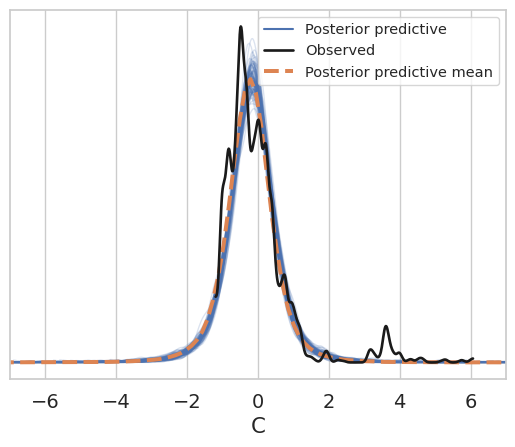

In [ ]:
fig, ax = plt.subplots()
ax.set_xlim(-7,7)
az.plot_ppc(trace_h1_studentT, num_pp_samples=100, figsize=(10, 5), random_seed=rng, ax = ax)

Looking the plot from the *posterior predictive check* we see that the model is able to recreate the observed data quite precisely. Addtionally, the model fits it much better than the previous model (with a $\text{Normal}$ distribution for $C$), as can be seen by the mean being almost exactly on top of the observed. Also, notice how the outliers are now unable to "pull" in at the posterior probability distribution.

Now, we have verified our priors and done a posterior predictive check, we are ready to take a look at the contrasts.

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

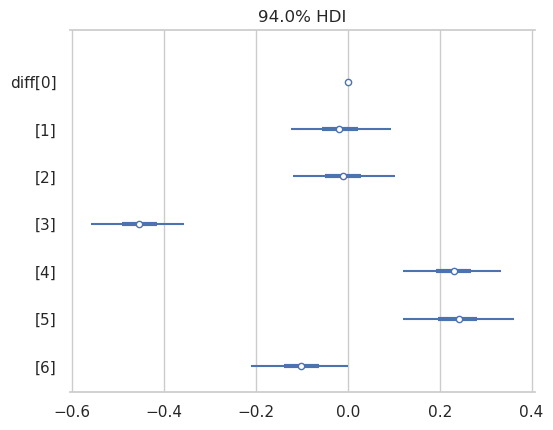

In [49]:
az.plot_forest(trace_h1_studentT, var_names=["diff"], combined=True)

Interestingly, `c-sharp-razor` now sits somewhere in the middle, with applications `ruby-sinatra` (5) and `python-flask` (4) consuming more energy. This is a very different view from that of the first model where `c-sharp-razor` was the worst the performing. This suggests that `c-sharp-razor` may be the most prone to outliers, which is not entirely unimaginable given it is a garbage-collected and JIT compiled language, so we would expect some number of requests is needed before such applications run at their best.  

**TODO: Explain the results from the StudenT model.**


**TODO: Motivate why running time is interesting because of the results from the previous models**

In [52]:
with pm.Model() as m_h1_with_runningtime:
    alpha = pm.Normal("alpha", 0,1)
    sigma = pm.Exponential("sigma", 1)
    beta  = pm.Normal("beta", 0,1, shape=df["A"].unique().size)

    C_data = pm.Data("C_data", df["C_stand"].values, mutable=True)
    A_data = pm.Data("A_data", df["A"].values, mutable=True)
    R_data = pm.Data("R_data", df["R_stand"].values, mutable=True)

    mu = pm.Deterministic("mu", alpha + beta[A_data] * R_data)
    C = pm.StudentT("C", nu=3, mu=mu, sigma=sigma, observed=C_data)

    diff = pm.Deterministic("diff", beta - beta[0])

    trace_h1_with_runningtime = pm.sample(random_seed=rng, idata_kwargs = { 'log_likelihood': True })

/home/chobbie/anaconda3/envs/prpro-2025/lib/python3.12/site-packages/pymc/data.py:440: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [53]:
az.summary(trace_h1_with_runningtime, var_names=["alpha", "beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.034,0.001,-0.035,-0.033,0.0,0.0,3852.0,3061.0,1.0
beta[0],0.949,0.001,0.947,0.951,0.0,0.0,5073.0,2675.0,1.0
beta[1],0.930,0.002,0.926,0.933,0.0,0.0,4478.0,2759.0,1.0
beta[2],0.930,0.002,0.927,0.933,0.0,0.0,5070.0,3076.0,1.0
beta[3],0.923,0.002,0.920,0.926,0.0,0.0,5126.0,3494.0,1.0
beta[4],0.928,0.002,0.924,0.932,0.0,0.0,5156.0,2944.0,1.0
beta[5],0.931,0.002,0.928,0.934,0.0,0.0,5007.0,2899.0,1.0
beta[6],0.934,0.002,0.930,0.938,0.0,0.0,4753.0,3187.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

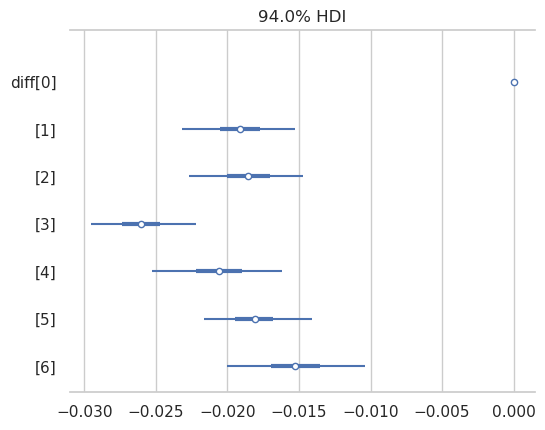

In [54]:
az.plot_forest(trace_h1_with_runningtime, var_names=["diff"], combined=True)

Interesting - per running time in seconds C\# performs worse than the other languages.

**TODO: Motivate why comparing is fun**

In [55]:
az.compare({'Normal':trace_h1_only_intercept, 'StudentT':trace_h1_studentT, 'with runningtime': trace_h1_with_runningtime}, ic='waic')

/home/chobbie/anaconda3/envs/prpro-2025/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
with runningtime,0,3511.315145,8.483679,0.000000,0.946027,117.218936,0.000000,False,log
StudentT,1,-2147.642979,9.164140,5658.958124,0.017876,58.809693,100.918216,False,log
Normal,2,-2544.998997,10.919304,6056.314142,0.036097,60.343609,103.911833,True,log


**TODO: What do theese results tell us?**

We see that the model using a lognormal likelihood has a better predictive capability. 
- elpd_waic is higher (because we are not on deviance scale). 
- p_waic (effective parameters) is also lower 
- weight = bigger

## Conclusion on H1

- We don't know enough about the data gathering process for a decisive conclusion

#### Notes:

- C\# energy consumption may be high because of garbage collection or JIT may result in longer requests. More energy spent on GC and JIT.
-  

----

## If time permits?

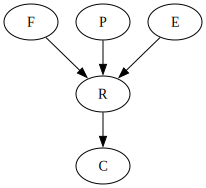

In [ ]:
from causalgraphicalmodels import CausalGraphicalModel

potential1 = CausalGraphicalModel(["P", "F", "R","C", "E"], [("P", "R"), ("F", "R"), ("R", "C"), ("E", "R")])
potential1.draw()


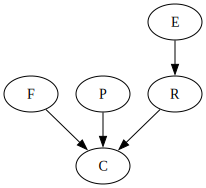

In [ ]:
potential2 = CausalGraphicalModel(["P", "F", "R","C", "E"], [("R","C"), ("E","R"), ("F","C"), ("P", "C")])
potential2.draw()

In [ ]:
df["L"] = pd.Categorical(df["language"]).codes
df["F"] = pd.Categorical(df["framework"]).codes
df.groupby('language').endpoint.nunique().reset_index().sort_values('endpoint', ascending=False)

,language,endpoint
0,c-sharp,14
1,go,14
2,javascript,14
3,python,14
4,ruby,14
5,rust,14


In [ ]:
# with pm.Model() as m_h2_lognormal:
#     sigma = pm.Exponential("sigma", 1)
#     # shape defines a vector size (+1 because ids start from zero)
#     # we will have four different mu's for K
#     mu_L = pm.Normal("mu_L", 0, 1, shape=(df["L"].max() + 1,))
#     mu_F = pm.Normal("mu_F", 0, 1, shape=(df["F"].unique().size))
#     # it is crazy implicit how pymc matches rows in d["clade_id"] and d["K"]
#     consumption = pm.LogNormal("consumption", mu_L[df["L"].values] + mu_F[df["F"].values], sigma, observed=df["energy_consumption"])

#     trace_h2_lognormal = pm.sample(random_seed = rng, idata_kwargs = { 'log_likelihood': True })
#     pm.sample_posterior_predictive(trace_h2_lognormal, extend_inferencedata=True, random_seed=rng)

In [ ]:
# az.plot_forest(trace_h2_lognormal, var_names=["mu_L", "mu_F"], combined=True)